## Neural Network for Bus ETA Calculation

This neural network is designed to calculate the Estimated Time of Arrival (ETA) for buses. It takes the following inputs:

- **Route ID**: The unique identifier for the bus route.
- **Starting Stop**: The bus stop where the journey begins.
- **Destination Stop**: The bus stop where the journey ends.
- **Weather Data**: Including precipitation, temperature, etc.
- **Time of Day**: The specific time when the journey starts.
- **Day of the Week**: The day on which the journey takes place.

Using these inputs, the neural network processes the data and outputs the duration of the journey in minutes and seconds. This helps in providing accurate and reliable ETA for bus passengers.

In [233]:
# Import required libraries
import datetime
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [234]:
# Check if the model is running on GPU or CPU
print(torch.cuda.is_available()) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [235]:
# Load data using pandas
df = pd.read_parquet("/data/scratch/shaivilp/two_l_mega_df.parquet")

In [236]:
# Drop any missing values
df = df.dropna()
df = df.dropna(subset=["eta_seconds"])
#Check if there are any missing values after dropping them
print(df.isna().any().any()) 

False


In [237]:
# Encode categorical features using LabelEncoder
label_encoders = {}
categorical_features = ['routeID', 'lastStopID', 'nextStopID_actual']

for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store the encoders for future decoding

# Display transformed data
df.head()

,routeID,patternID,equipmentID,tripID,lat,lng,load,capacity,eLoad,blockID,...,nextToLast_right,timeDiff_right,receiveTime_right,nextStopID_actual,nextStopName_actual,eta,hour_of_day,minute_of_hour,day_of_week,eta_seconds
0,0,3,Old_1501,329.0,41.93639,-88.77360,0,0,33,0,...,True,0 days 00:01:00,2024-09-01 00:05:21,17,Stadium Dr. at New Hall,0 days 00:00:40,0,4,7,40
1,0,3,1103,330.0,41.93639,-88.77435,0,0,0,0,...,True,0 days 00:00:50,2024-09-01 00:35:16,17,Stadium Dr. at New Hall,0 days 00:00:41,0,34,7,41
2,0,3,1103,331.0,41.93638,-88.77397,0,0,8,0,...,True,0 days 00:01:00,2024-09-01 01:04:25,17,Stadium Dr. at New Hall,0 days 00:00:51,1,3,7,51
3,0,3,1103,332.0,41.93639,-88.77435,0,0,18,0,...,True,0 days 00:00:50,2024-09-01 01:34:37,17,Stadium Dr. at New Hall,0 days 00:00:51,1,33,7,51
4,0,3,1103,338.0,41.93640,-88.77528,0,0,31,0,...,True,0 days 00:00:50,2024-09-01 02:04:35,17,Stadium Dr. at New Hall,0 days 00:00:30,2,4,7,30


In [238]:
# Normalize numerical features using MixScalers
numerical_features = ['hour_of_day', 'minute_of_hour', 'day_of_week']
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Display normalized data
df.head()

,routeID,patternID,equipmentID,tripID,lat,lng,load,capacity,eLoad,blockID,...,nextToLast_right,timeDiff_right,receiveTime_right,nextStopID_actual,nextStopName_actual,eta,hour_of_day,minute_of_hour,day_of_week,eta_seconds
0,0,3,Old_1501,329.0,41.93639,-88.77360,0,0,33,0,...,True,0 days 00:01:00,2024-09-01 00:05:21,17,Stadium Dr. at New Hall,0 days 00:00:40,0.000000,0.067797,1.0,40
1,0,3,1103,330.0,41.93639,-88.77435,0,0,0,0,...,True,0 days 00:00:50,2024-09-01 00:35:16,17,Stadium Dr. at New Hall,0 days 00:00:41,0.000000,0.576271,1.0,41
2,0,3,1103,331.0,41.93638,-88.77397,0,0,8,0,...,True,0 days 00:01:00,2024-09-01 01:04:25,17,Stadium Dr. at New Hall,0 days 00:00:51,0.043478,0.050847,1.0,51
3,0,3,1103,332.0,41.93639,-88.77435,0,0,18,0,...,True,0 days 00:00:50,2024-09-01 01:34:37,17,Stadium Dr. at New Hall,0 days 00:00:51,0.043478,0.559322,1.0,51
4,0,3,1103,338.0,41.93640,-88.77528,0,0,31,0,...,True,0 days 00:00:50,2024-09-01 02:04:35,17,Stadium Dr. at New Hall,0 days 00:00:30,0.086957,0.067797,1.0,30


In [239]:
# Normalize the target variable before creating the dataset
scaler_eta = MinMaxScaler()
df['eta_seconds'] = scaler_eta.fit_transform(df[['eta_seconds']])  # Fit on the full dataset

In [240]:
# Define feature matrix (X) and target vector (y)
df = df.dropna(subset=['eta_seconds'])  # Drop rows with NaN in target

# Convert to PyTorch tensors
X_tensor = torch.tensor(df[categorical_features + numerical_features].values, dtype=torch.float32)
y_tensor = torch.tensor(df['eta_seconds'].values, dtype=torch.float32).view(-1, 1)

# Print tensor shapes
print(f"Feature tensor shape: {X_tensor.shape}")
print(f"Target tensor shape: {y_tensor.shape}")

Feature tensor shape: torch.Size([58178, 6])
Target tensor shape: torch.Size([58178, 1])


In [241]:
# Move tensors to GPU if available
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

In [242]:
print(torch.isnan(X_tensor).sum())  # Should be 0
print(torch.isinf(X_tensor).sum())  # Should be 0
print(torch.isnan(y_tensor).sum())  # Should be 0
print(torch.isinf(y_tensor).sum())  # Should be 0

tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')


In [243]:
# Define a PyTorch dataset class
class ETADataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            self.X[idx],
            self.y[idx],
        )
# Create dataset
dataset = ETADataset(X_tensor, y_tensor)

# Print dataset length
print(f"Dataset size: {len(dataset)}")

Dataset size: 58178


In [244]:
# Define train-validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Perform split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Training samples: 46542, Validation samples: 11636


In [245]:
# Define the ETA prediction neural network
class ETANetwork(nn.Module):
    def __init__(self, input_size):
        super(ETANetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize model
model = ETANetwork(input_size=X_tensor.shape[1])

model.to(device)

# Print model architecture
print(model)

ETANetwork(
  (model): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [246]:
# Define loss function and optimizer
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [247]:
# Training function
train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    print("Training Started 🚀")
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)

            loss.backward()
                        
            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()
        
        # Compute averages
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        #Print results for monitoring
        print(f"Epoch {epoch+1}/{epochs} ➝ "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f}")
        
        # Store losses for future analysis
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Overfitting warning
        if avg_train_loss < avg_val_loss * 0.8:
            print("⚠️ Warning: Possible overfitting detected!")
            
    print("Training complete ✅")
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=40)

Training Started 🚀
Epoch 1/40 ➝ Train Loss: 0.0118 | Val Loss: 0.0096
Epoch 2/40 ➝ Train Loss: 0.0080 | Val Loss: 0.0071
Epoch 3/40 ➝ Train Loss: 0.0065 | Val Loss: 0.0063
Epoch 4/40 ➝ Train Loss: 0.0061 | Val Loss: 0.0060
Epoch 5/40 ➝ Train Loss: 0.0059 | Val Loss: 0.0064
Epoch 6/40 ➝ Train Loss: 0.0057 | Val Loss: 0.0058
Epoch 7/40 ➝ Train Loss: 0.0056 | Val Loss: 0.0058
Epoch 8/40 ➝ Train Loss: 0.0054 | Val Loss: 0.0058
Epoch 9/40 ➝ Train Loss: 0.0053 | Val Loss: 0.0055
Epoch 10/40 ➝ Train Loss: 0.0052 | Val Loss: 0.0053
Epoch 11/40 ➝ Train Loss: 0.0051 | Val Loss: 0.0052
Epoch 12/40 ➝ Train Loss: 0.0050 | Val Loss: 0.0053
Epoch 13/40 ➝ Train Loss: 0.0049 | Val Loss: 0.0051
Epoch 14/40 ➝ Train Loss: 0.0048 | Val Loss: 0.0049
Epoch 15/40 ➝ Train Loss: 0.0047 | Val Loss: 0.0053
Epoch 16/40 ➝ Train Loss: 0.0046 | Val Loss: 0.0046
Epoch 17/40 ➝ Train Loss: 0.0044 | Val Loss: 0.0046
Epoch 18/40 ➝ Train Loss: 0.0042 | Val Loss: 0.0043
Epoch 19/40 ➝ Train Loss: 0.0041 | Val Loss: 0.0042
Ep

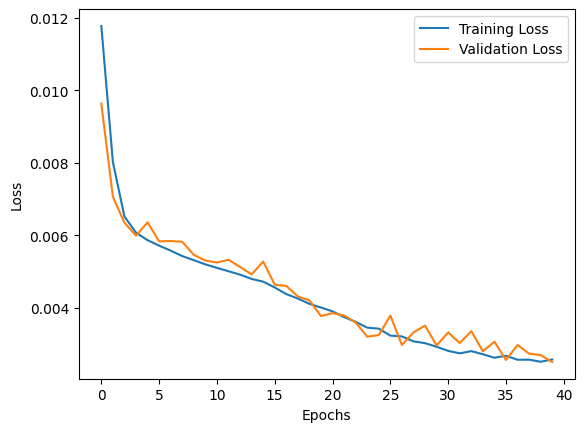

In [248]:
# Check for overfitting
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [249]:
model.eval()
with torch.no_grad():
    sample_X, sample_y= next(iter(val_loader))
    predictions = model(sample_X)

# Convert to NumPy and reshape
sample_y_original = scaler_eta.inverse_transform(sample_y.cpu().numpy())
predictions_original = scaler_eta.inverse_transform(predictions.cpu().numpy())

# Print first 15 predictions vs actual values
for i in range(15):
    predicted_eta = str(datetime.timedelta(seconds=int(predictions_original[i][0])))
    actual_eta = str(datetime.timedelta(seconds=int(sample_y_original[i][0])))
    print(f"Predicted ETA: {predicted_eta}, Actual ETA: {actual_eta}")

Predicted ETA: 0:00:42, Actual ETA: 0:01:20
Predicted ETA: 0:01:46, Actual ETA: 0:02:20
Predicted ETA: 0:04:07, Actual ETA: 0:03:40
Predicted ETA: 0:12:40, Actual ETA: 0:15:20
Predicted ETA: 0:12:47, Actual ETA: 0:15:52
Predicted ETA: 0:02:50, Actual ETA: 0:02:41
Predicted ETA: 0:03:24, Actual ETA: 0:01:30
Predicted ETA: 0:00:48, Actual ETA: 0:01:30
Predicted ETA: 0:04:30, Actual ETA: 0:04:20
Predicted ETA: 0:10:28, Actual ETA: 0:08:41
Predicted ETA: 0:01:42, Actual ETA: 0:01:10
Predicted ETA: 0:02:31, Actual ETA: 0:03:41
Predicted ETA: 0:02:57, Actual ETA: 0:02:30
Predicted ETA: 0:02:48, Actual ETA: 0:00:59
Predicted ETA: 0:02:08, Actual ETA: 0:02:30


In [250]:
print(f"Min ETA: {y_tensor.min().item()}, Max ETA: {y_tensor.max().item()}")
print(f"Mean ETA: {y_tensor.mean().item()}, Std ETA: {y_tensor.std().item()}")

Min ETA: 0.0, Max ETA: 1.0
Mean ETA: 0.19030579924583435, Std ETA: 0.1795668751001358
